In [2]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "scatter", "no-latex"])

In [3]:
# regex patterns
PATTERNS = {
    "Status": re.compile(r"^\s*Status\s*:\s*(\S+)"),
    "Precondition time": re.compile(r"^\s*Precondition time\s*:\s*([\deE\+\-\.]+)"),
    "Iterations": re.compile(r"^\s*Iterations\s*:\s*(\d+)"),
    "Solve time": re.compile(r"^\s*Solve time\s*:\s*([\deE\+\-\.]+)"),
    "Primal obj": re.compile(r"^\s*Primal obj\s*:\s*([\deE\+\-\.]+)"),
    "Dual obj": re.compile(r"^\s*Dual obj\s*:\s*([\deE\+\-\.]+)")
}

## Parse Summary

In [5]:
def parse_slurm_file(path):
    """
    Parse a single slurm file
    """
    # init result
    results = {}
    current_instance = None

    # read lines
    with open(path, "r") as f:
        lines = f.readlines()

    # get info
    for line in lines:
        # detect a new instance
        m = re.search(r"^Instance:\s+(\S+)", line)
        if m:
            # init info for current instance
            current_instance = m.group(1)
            results[current_instance] = {
                "Status": None,
                "Precondition time": None,
                "Iterations": None,
                "Solve time": None,
                "Primal obj": None,
                "Dual obj": None,
            }
            continue

        # skip if not an instance
        if current_instance is None:
            continue

        # match field
        for field, pat in PATTERNS.items():
            m = pat.search(line)
            # store info
            if m:
                value = m.group(1)
                results[current_instance][field] = m.group(1)

    return results

In [6]:
def load_benchmark(job_id):
    """
    Parse *.out files for a job id, merge their results, and return a pandas DataFrame
    """
    # files dir
    f1 = f".\\slurm\\slurm-c-vtx-benchmark-{job_id}_1.out"
    f2 = f".\\slurm\\slurm-c-vtx-benchmark-{job_id}_2.out"

    # existence check
    if not os.path.exists(f1) or not os.path.exists(f2):
        raise FileNotFoundError("Some slurm files not found.")

    # parse files
    r1 = parse_slurm_file(f1)
    r2 = parse_slurm_file(f2)

    # merrge the two results
    merged = merge_results(r1, r2)

    # convert to a DataFrame
    df = pd.DataFrame.from_dict(merged, orient="index")
    df.index.name = "Instance"
    return df

def merge_results(res1, res2):
    """
    Merge the parsed results from two files.
    """
    # init merged results
    merged = {}
    # union instance
    all_instances = set(res1.keys()) | set(res2.keys())

    for inst in all_instances:
        # instance existence check
        if inst not in res1 or inst not in res2:
            print(f"[WARNING] Instance {inst} missing in one file.")
            continue

        # get per-instance records
        r1, r2 = res1[inst], res2[inst]
        # init field for current instance
        merged[inst] = {}

        # numeric average
        merged[inst]["Precondition time"] = (float(r1["Precondition time"]) + float(r2["Precondition time"])) / 2
        merged[inst]["Solve time"] = (float(r1["Solve time"]) + float(r2["Solve time"])) / 2
        # check consistency for others
        for field in ["Status", "Iterations", "Primal obj", "Dual obj"]:
            if r1[field] != r2[field]:
                print(f"[WARNING] mismatch in {field} for instance {inst}: {r1[field]} vs {r2[field]}")
            merged[inst][field] = r1[field]
    return merged

In [7]:
def load_two_jobs(job1, job2):
    """
    Load and merge results from two benchmarks
    """
    # load per-job benchmark results
    df1 = load_benchmark(job1)
    df2 = load_benchmark(job2)

    # find duplicated instances
    overlap = df1.index.intersection(df2.index)
    for inst in overlap:
        print(f"[WARNING] duplicate instance '{inst}' found in both jobs "
              f"({job1} & {job2}); keeping job {job1}'s entry.")

    # drop duplicated instances from df2
    df2 = df2.drop(index=overlap)

    # concatenate along rows
    df_merged = pd.concat([df1, df2], axis=0)
    return df_merged

In [8]:
df_CPU = load_two_jobs(6635649, 6635652)
df_GPU = load_two_jobs(6578038, 6578043)

[WARNING] mismatch in Iterations for instance physiciansched3-3: 52986800 vs 73923200
[WARNING] mismatch in Primal obj for instance physiciansched3-3: 2432689.742 vs 2432682.375
[WARNING] mismatch in Dual obj for instance physiciansched3-3: 2432616.795 vs 2432263.421
[WARNING] mismatch in Iterations for instance ns1687037: 247379000 vs 245363200
[WARNING] mismatch in Primal obj for instance ns1687037: 4.673210786 vs 4.674771257
[WARNING] mismatch in Dual obj for instance ns1687037: -250.2518284 vs -250.5478898
[WARNING] mismatch in Iterations for instance ds-big: 933200 vs 246200
[WARNING] mismatch in Primal obj for instance ds-big: 86.83684649 vs 86.87730779
[WARNING] mismatch in Dual obj for instance ds-big: 86.81978274 vs 86.86340735
[WARNING] mismatch in Iterations for instance neos-4535459-waipa: 7867000 vs 8006800
[WARNING] mismatch in Primal obj for instance neos-4535459-waipa: 3.059144606e+15 vs 3.043069589e+15
[WARNING] mismatch in Dual obj for instance neos-4535459-waipa: -4.

## Check Consistency

In [10]:
def check_cpu_gpu_consistency(df_CPU, df_GPU, tol=1e-6):
    """
    Check consistency of key fields between CPU and GPU benchmark results.
    """
    # get instances
    common = df_CPU.index.intersection(df_GPU.index)

    # for each instance
    mismatch_count = 0
    for inst in common:
        rC = df_CPU.loc[inst]
        rG = df_GPU.loc[inst]

        # comparison with tolerance
        for field in ["Primal obj", "Dual obj"]:
            fC = float(rC[field])
            fG = float(rG[field])
            if abs(fC - fG) > tol:
                print(f"[WARNING] mismatch in {field} for instance {inst}:")
                # print a comparison table
                display_df = pd.DataFrame([rC, rG], index=["CPU", "GPU"])[["Status", "Iterations", "Primal obj", "Dual obj"]]
                print(display_df.to_string())
                print("-" * 60)
                mismatch_count += 1
                break

    print(f"Total mismatches: {mismatch_count} / {len(common)} instances")

In [11]:
check_cpu_gpu_consistency(df_CPU, df_GPU)

[WARNING] mismatch in Dual obj for instance bdry2:
      Status Iterations      Primal obj        Dual obj
CPU  OPTIMAL   33554200  0.004177643673  0.004222602356
GPU  OPTIMAL   33558800  0.004177664638  0.004227880325
------------------------------------------------------------
[WARNING] mismatch in Primal obj for instance physiciansched3-3:
      Status Iterations   Primal obj     Dual obj
CPU  OPTIMAL   52986800  2432689.742  2432616.795
GPU  OPTIMAL   54340200   2432694.06  2432526.403
------------------------------------------------------------
[WARNING] mismatch in Primal obj for instance ns1687037:
         Status Iterations   Primal obj      Dual obj
CPU  TIME_LIMIT  247379000  4.673210786  -250.2518284
GPU  TIME_LIMIT  250602000   4.64700347  -249.3609757
------------------------------------------------------------
[WARNING] mismatch in Dual obj for instance satellites2-25:
      Status Iterations    Primal obj      Dual obj
CPU  OPTIMAL       5100  -30.00002622  -29.99759189


## Visualization

In [13]:
def plot_cpu_gpu_comparison(df_CPU, df_GPU):
    """
    CPU vs GPU time comparison.
    """
    # find common instances
    dfC = df_CPU.copy()
    dfG = df_GPU.copy()
    common = dfC.index.intersection(dfG.index)

    # extract times
    cpu_pre = dfC["Precondition time"].astype(float)
    gpu_pre = dfG["Precondition time"].astype(float)
    cpu_sol = dfC["Solve time"].astype(float)
    gpu_sol = dfG["Solve time"].astype(float)

    # color palette
    cmap = plt.get_cmap("tab10")
    color_pre = cmap(0)
    color_sol = cmap(1)
    edge_color = "black"

    # ============================================================
    # Figure 1 — Precondition Time
    # ============================================================
    plt.figure(figsize=(7, 6))
    # scatter points
    plt.scatter(cpu_pre, gpu_pre, s=45, alpha=0.8, color=color_pre, edgecolors=edge_color, linewidth=0.8)
    # y = x line
    max_pre = max(cpu_pre.max(), gpu_pre.max())
    plt.plot([0, max_pre], [0, max_pre], "k--", linewidth=1)
    # label
    plt.title("Precondition Time: CPU vs GPU", fontsize=24, fontweight="bold")
    plt.xlabel("CPU Precondition Time (sec)", fontsize=20)
    plt.ylabel("GPU Precondition Time (sec)", fontsize=20)
    # Log scale
    #plt.xscale("log")
    #plt.yscale("log")
    # layout
    plt.tick_params(axis="both", which="major", labelsize=16)
    plt.tight_layout()
    plt.show()
    # ============================================================
    # Figure 2 — Solve Time
    # ============================================================
    plt.figure(figsize=(7, 6))
    # scatter points
    plt.scatter(cpu_sol, gpu_sol, s=45, alpha=0.8, color=color_sol, edgecolors=edge_color, linewidth=0.8)
    # y = x line
    max_sol = max(cpu_sol.max(), gpu_sol.max())
    plt.plot([0, max_sol], [0, max_sol], "k--", linewidth=1)
    # label
    plt.title("Solve Time: CPU vs GPU", fontsize=24, fontweight="bold")
    plt.xlabel("CPU Solve Time (sec)", fontsize=20)
    plt.ylabel("GPU Solve Time (sec)", fontsize=20)
    # layout
    plt.tick_params(axis="both", which="major", labelsize=16)
    plt.tight_layout()
    plt.show()

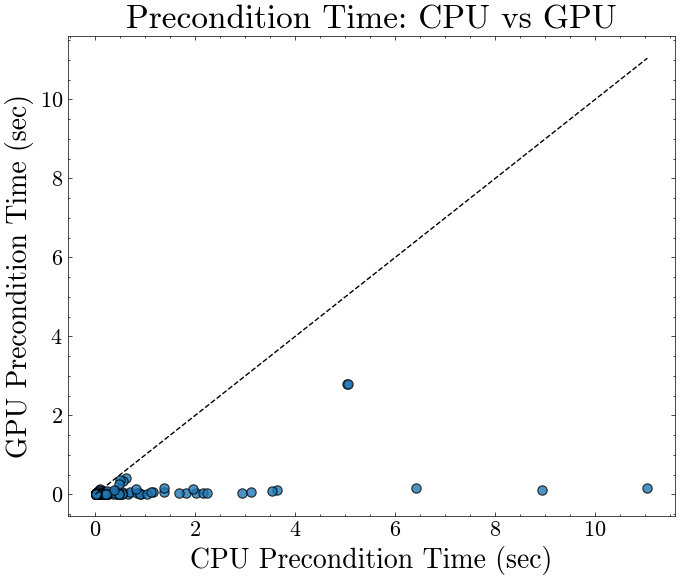

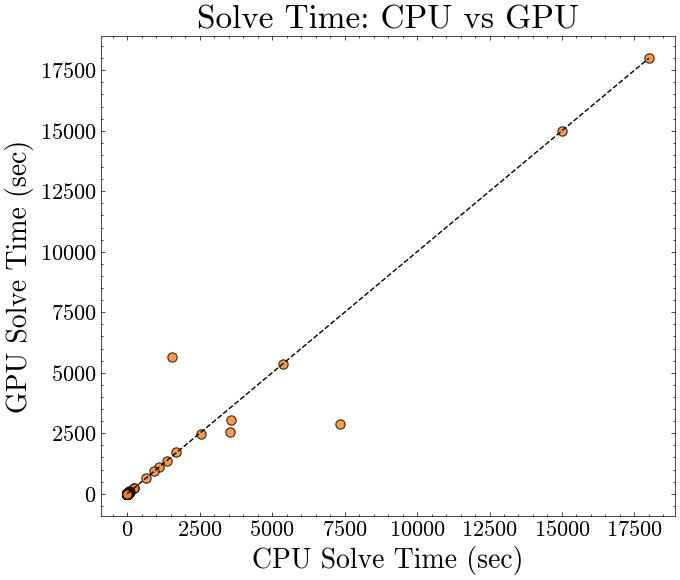

In [14]:
plot_cpu_gpu_comparison(df_CPU, df_GPU)